## Connect to Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Library

In [2]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle
import shutil

### Parameter

In [45]:
IMAGE_SIZE = 128

### Download Datasets

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

100%|██████████| 149M/149M [00:00<00:00, 221MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


### Move dataset to google drive

In [4]:
shutil.move(path, "/content/drive/MyDrive/Colab Notebooks/brain_tumor")

'/content/drive/MyDrive/Colab Notebooks/brain_tumor/1'

### Load Datasets

In [38]:
# Load train dataset
train_dir = "/content/drive/MyDrive/Colab Notebooks/brain_tumor/1/Training/"

train_paths = []
train_labels = []
for label in os.listdir(train_dir):
  for image in os.listdir(os.path.join(train_dir, label)):
    train_paths.append(os.path.join(train_dir, label, image))
    train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

In [39]:
# Load test dataset
test_dir = "/content/drive/MyDrive/Colab Notebooks/brain_tumor/1/Testing/"

test_paths = []
test_labels = []
for label in os.listdir(test_dir):
  for image in os.listdir(os.path.join(test_dir, label)):
    test_paths.append(os.path.join(test_dir, label, image))
    test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

### Data Visualization

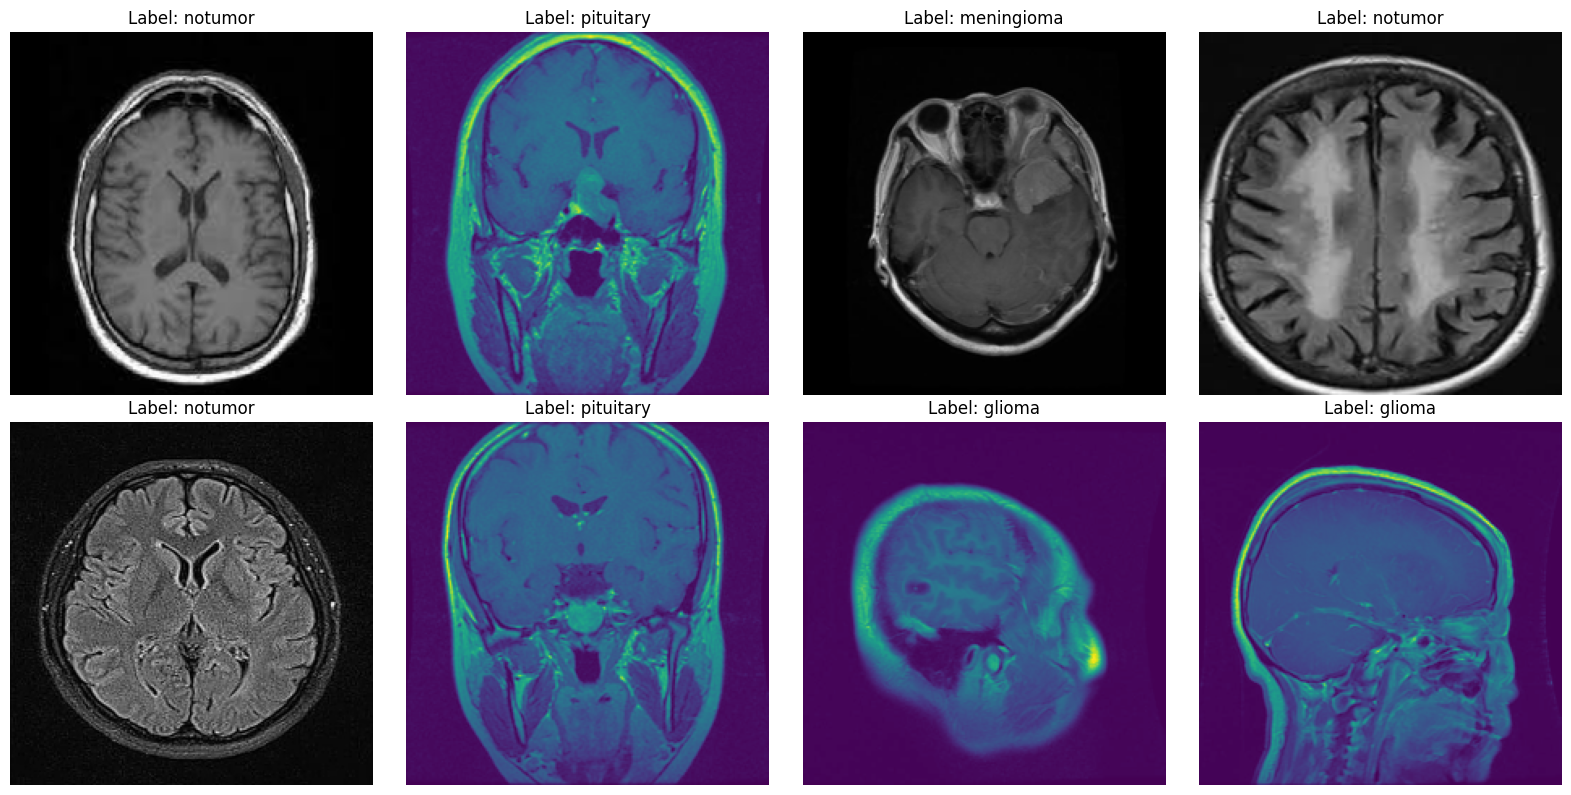

In [40]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

random_images = random.sample(range(len(train_paths)), 8)
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for i, idx in enumerate(random_images):
  img_path = train_paths[idx]
  img = Image.open(img_path)
  img = img.resize((224, 224))

  axes[i].imshow(img)
  axes[i].axis('off')
  axes[i].set_title(f"Label: {train_labels[idx]}")

plt.tight_layout()
plt.show()

### Image Preprocessing

In [41]:
def augment_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
  image = np.array(image) / 255.0
  return image

In [46]:
def open_images(paths):
  images = []
  for path in paths:
    image = load_img(path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    image = augment_image(image)
    images.append(image)
  return np.array(images)

In [43]:
def encode_label(labels):
  unique_labels = os.listdir(train_dir)
  encoded = [unique_labels.index(label) for label in labels]
  return np.array(encoded)

In [44]:
def datagen(paths, labels, batch_size=12, epochs=1):
  for _ in range(epochs):
    for i in range(0, len(paths), batch_size):
      batch_paths = paths[i:i + batch_size]
      batch_images = open_images(batch_paths)
      batch_labels = labels[i:i + batch_size]
      batch_labels = encode_label(batch_labels)
      yield batch_images, batch_labels

## MODEL

In [47]:
base_model = VGG16(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, weights='imagenet')

for layer in base_model.layers:
  layer.trainable = False

base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [49]:
model = Sequential()
model.add(Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,763,908 (60.13 MB)

 Trainable params: 8,128,644 (31.01 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [50]:
batch_size = 20
epochs = 5
steps = int(len(train_paths) / batch_size)

In [51]:
history = model.fit(datagen(train_paths, train_labels, batch_size=batch_size, epochs=epochs),
                    epochs=epochs, steps_per_epoch=steps)

Epoch 1/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 907s 3s/step - loss: 0.6444 - sparse_categorical_accuracy: 0.7495
Epoch 2/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 907s 3s/step - loss: 0.2376 - sparse_categorical_accuracy: 0.9127
Epoch 3/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 909s 3s/step - loss: 0.1626 - sparse_categorical_accuracy: 0.9444
Epoch 4/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 905s 3s/step - loss: 0.1186 - sparse_categorical_accuracy: 0.9529
Epoch 5/5
285/285 ━━━━━━━━━━━━━━━━━━━━ 914s 3s/step - loss: 0.0971 - sparse_categorical_accuracy: 0.9662


In [54]:
# Save model
from pickle import load, dump

model.save("/content/drive/MyDrive/Colab Notebooks/brain_tumor/model/model.keras")

with open("/content/drive/MyDrive/Colab Notebooks/brain_tumor/model/history.pkl", "wb") as f:
  dump(history.history, f)

### Predict

In [73]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

class_labels = ["notumor", "glioma", "meningioma", "pituitary"]

def detect_and_display(img_path, model, image_size=128):
    try:
        # Load and preprocess the image
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img) / 255.0  # Normalize pixel values
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

        # Make a prediction
        predictions = model.predict(img_array)
        predicted_class_index = np.argmax(predictions, axis=1)[0]
        confidence_score = np.max(predictions, axis=1)[0]

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = "No Tumor"
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with the prediction
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()

    except Exception as e:
        print("Error processing the image:", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


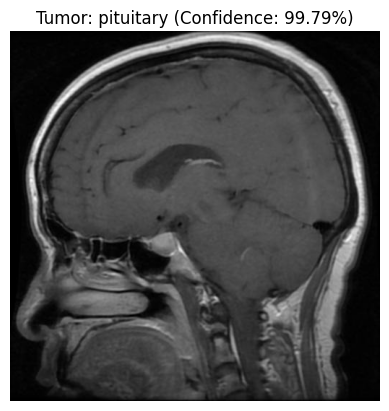

In [70]:
image_path = '/content/drive/MyDrive/Colab Notebooks/brain_tumor/1/Testing/pituitary/Te-piTr_0003.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


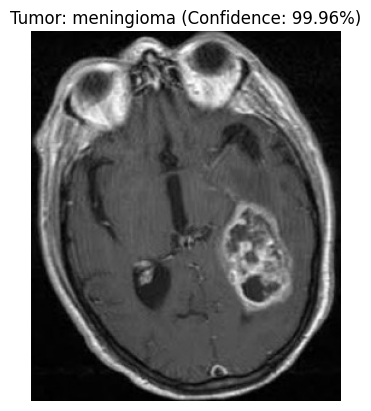

In [71]:
image_path = '/content/drive/MyDrive/Colab Notebooks/brain_tumor/1/Testing/meningioma/Te-meTr_0001.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


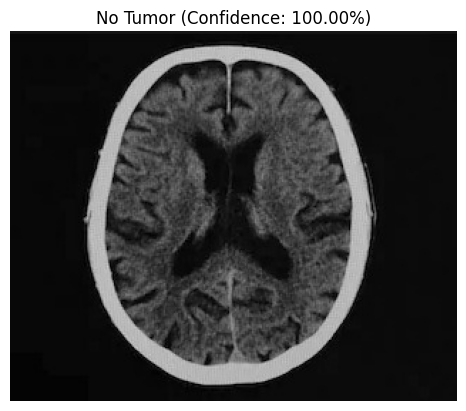

In [74]:
image_path = '/content/drive/MyDrive/Colab Notebooks/brain_tumor/1/Testing/notumor/Te-noTr_0005.jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


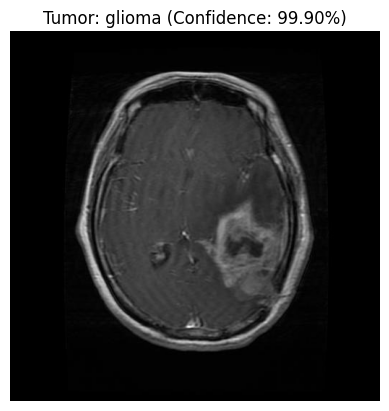

In [75]:
image_path = '/content/drive/MyDrive/Colab Notebooks/brain_tumor/1/Testing/glioma/Te-gl_0022.jpg'
detect_and_display(image_path, model)

# Train and Val Plot

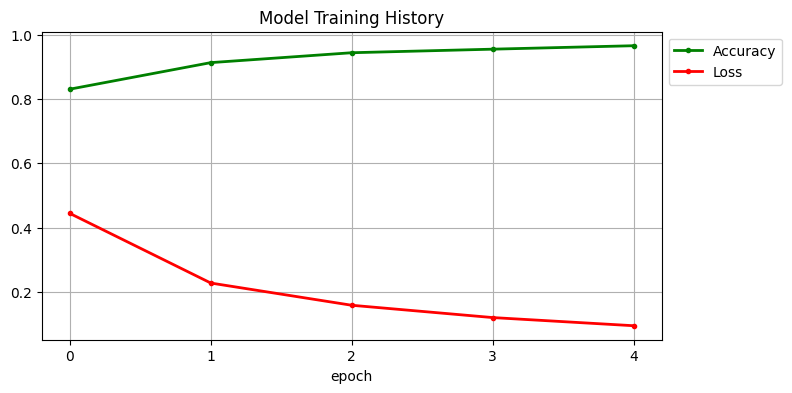

In [76]:
from pickle import load

with open("/content/drive/MyDrive/Colab Notebooks/brain_tumor/model/history.pkl", "rb") as f:
  history = load(f)

plt.figure(figsize=(8,4))
plt.grid(True)
plt.plot(history['sparse_categorical_accuracy'], '.g-', linewidth=2)
plt.plot(history['loss'], '.r-', linewidth=2)
plt.title('Model Training History')
plt.xlabel('epoch')
plt.xticks([x for x in range(epochs)])
plt.legend(['Accuracy', 'Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [77]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

test_images = open_images(test_paths)
test_labels_encoded = encode_label(test_labels)

test_predictions = model.predict(test_images)

print("Classification Report:")
print(classification_report(test_labels_encoded, np.argmax(test_predictions, axis=1)))

41/41 ━━━━━━━━━━━━━━━━━━━━ 171s 4s/step
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       405
           1       0.95      0.92      0.93       300
           2       0.93      0.91      0.92       306
           3       0.99      0.98      0.98       300

    accuracy                           0.96      1311
   macro avg       0.96      0.95      0.95      1311
weighted avg       0.96      0.96      0.96      1311



Confusion Matrix:
[[405   0   0   0]
 [  5 276  19   0]
 [  9  14 279   4]
 [  3   1   3 293]]


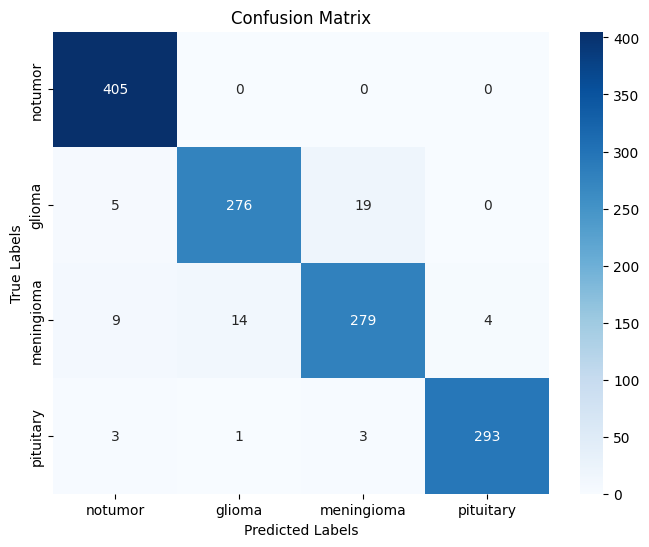

In [78]:
# 3. Confusion Matrix
conf_matrix = confusion_matrix(test_labels_encoded, np.argmax(test_predictions, axis=1))
print("Confusion Matrix:")
print(conf_matrix)

# Plot the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=os.listdir(train_dir), yticklabels=os.listdir(train_dir))
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

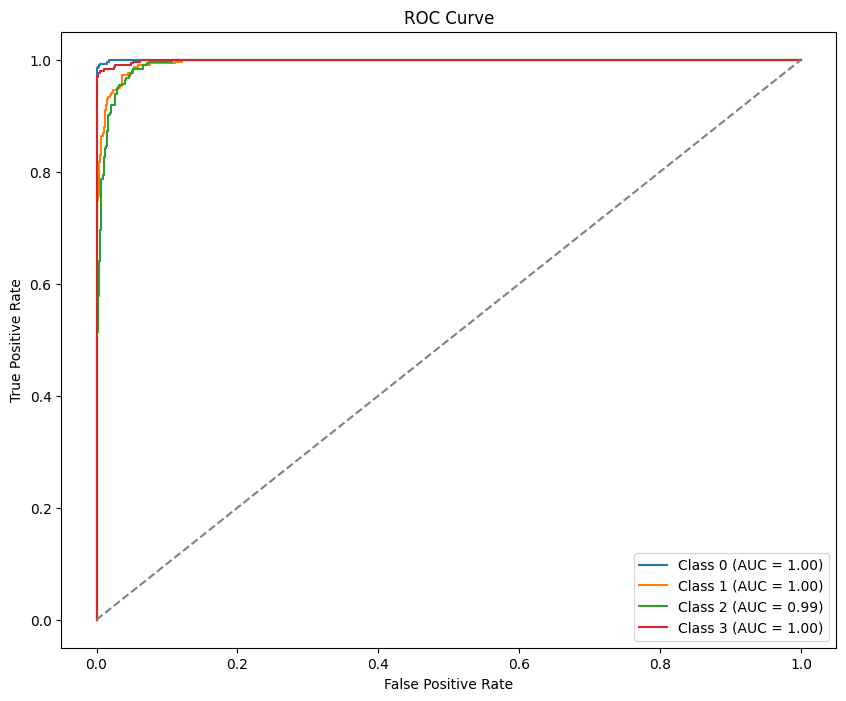

In [79]:
# 4. ROC Curve and AUC
# Binarize the test labels and predictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes=np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions  # The predicted probabilities for each class

# Compute ROC curve and ROC AUC for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(10, 8))
for i in range(len(os.listdir(train_dir))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()